# How to choose gifts from Sephora if you know nothing about makeup?
Girls love makeup products, and they also like surprises. So, naturally, sometimes they want their boyfriends (or guy friends in general) to give them makeup products as surprise gifts. Unfortunately, guys usually have very little sense about makeup, or not at all. Thus, choosing makeup products can be a great challenge for guys. I have a girlfriend who also loves makeup product, and I am one of the guys who knows nothing about it. **I visited Sephora - a very popular company that sells various make-ups - but I found it was hard to use its filter system as it only allows you to filter one criterion at a time.** For example, if you only want products with less than \\$100 and you filter the products by price, you won't be able to further sort the products by the number of reviews. I then realize that I can use my data science skills to help me find the products I want. **So in this notebook, I developed a script to help me automatically choose the best newly-arrived makeup products, within a given budget.**

## Script To Pick The Best Sephora Products
This script can automatically scrape the newly arrived makeup products in Sepora website, perform data cleaning, and select the best products based on the criteria I give. In the next section I will show how each step works.

In [101]:
import time
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
def pick_best_sephora_product(min_rating=4.5, min_num_reviews=0, min_num_likes=5000,
                              budget=100.0, filtered_words=None, combination=True):
    '''
    Algorithm which picks the best newly arrived Sephora makeup product with given budget. Products are evaluated based on the 
    ratings and the number of reviews.
    
    Parameters
    -----------
    min_rating : float
        Minimum rating threshold of the products
        
    min_num_reviews : int
        Minimum number of reviews threshold of the products
    
    min_num_likes : int
        Minimum number of likes threshold of the products
    
    budget : float
        Your budget
    
    filtered_words : list of strs
        The strings that contains in the filter will not be selected. E.g. if the filter is ['Brush'],
        then 'Brush' will not be selected
        
    combination : Boolean
        Whether choose one product (if False) or a combination of two products (if True)
        
        
    Returns
    ----------
    A Pandas dataframe which contains selected products.
    '''
    
    # Web scrapping urls
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_chrome85\chromedriver.exe")
    # Makeup website
    driver.get("https://www.sephora.com/ca/en/beauty/new-makeup")
    time.sleep(5)
    scroll_pause_time = 2
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    while True:
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  # scroll one screen height each time
        i += 1
        time.sleep(scroll_pause_time)
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  # update scroll height each time after scrolled
        if (screen_height) * i > scroll_height:
            break
    urls = []
    soup = BeautifulSoup(driver.page_source, "html.parser")
    for parent in soup.find_all(class_="css-1s223mm"):
        a_tag = parent.find("a", class_="css-ix8km1")
        base = "https://www.sephora.com/"
        link = a_tag.attrs['href']
        url = urljoin(base, link)
        urls.append(url)
    
    # Web scraping product information
    makeup = {'brand_name':[], 'product_name':[], 'rating_stars':[], 'num_reviews':[], 'num_likes': [], 'price_dollar':[]}
    for url in urls:
        driver.get(url)
        scroll_pause_time = 2
        screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
        i = 1
        while True:
            driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  # scroll one screen height each time
            i += 1
            time.sleep(scroll_pause_time)
            scroll_height = driver.execute_script("return document.body.scrollHeight;")  # update scroll height each time after scrolled
            if (screen_height) * i > scroll_height:
                break
        soup = BeautifulSoup(driver.page_source, "html.parser")    
        brand_name = soup.select("div.css-1xy0oe1.e65zztl0 h1 span.css-57kn72")[0].text
        product_name = soup.select("div.css-1xy0oe1.e65zztl0 h1 span.css-0")[0].text
        price = soup.select(".css-1865ad6.e65zztl0 span")[0].text
        num_likes = soup.select("div.css-fv3lde.e65zztl0 span span")[0].text
        try:
            rating = soup.select(".css-1kkx19h.eanm77i0")[0].text
            reviews = soup.select(".css-ils4e4.eanm77i0")[0].text
        except IndexError:
            # An IndexError occurs when there is no rating and review for the item
            rating = 0
            reviews = 0

        # Store each element in dictionary
        makeup['brand_name'].append(brand_name)
        makeup['product_name'].append(product_name)
        makeup['rating_stars'].append(rating)
        makeup['num_reviews'].append(reviews)
        makeup['num_likes'].append(num_likes)
        makeup['price_dollar'].append(price)
    
    # Close the website
    driver.quit()
    # Convert to dataframe
    makeup = pd.DataFrame(makeup)
    
    # Data cleaning
    makeup2 = makeup.copy()
    makeup2['rating_stars'] = makeup2['rating_stars'].str.replace(' / 5 stars', '').astype(float)
    makeup2['num_reviews'] = makeup2['num_reviews'].str.replace(r' reviews?', '').str.replace('K', '000').astype(float)
    makeup2['price_dollar'] = makeup2['price_dollar'].str.replace('$', '').astype(float)
    makeup2['num_likes'] = makeup2['num_likes'].str.replace('K', '').astype(float) * makeup['num_likes'].str.extract('(K)').fillna(1).replace('K', 1000).iloc[:, 0]
    makeup2 = makeup2.dropna()
    
    # Apply filters
    makeup2 = makeup2.loc[makeup2.price_dollar <= budget, :]
    if filtered_words != None:
        for filtered_word in filtered_words:
            makeup2 = makeup2.loc[~makeup2['product_name'].str.contains(filtered_word), :].reset_index(drop=True)
    makeup2 = makeup2.loc[(makeup2['rating_stars']>min_rating) & 
                          (makeup2['num_reviews']>min_num_reviews) & 
                          (makeup2['num_likes']>min_num_likes)].reset_index(drop=True)
    
    if combination == False:
        # Best single items
        makeup2 = makeup2.sort_values(by=['price_dollar', 'rating_stars', 'num_likes', 'num_reviews'], 
                                      ascending=False).reset_index(drop=True)
        return makeup2
    
    # Best combinations of two items
    makeup_two_combinations = {'combination':[], 'total_price_dollar':[], 
                           'total_rating_stars':[], 'total_num_likes':[], 'total_num_reviews':[]}

    for i in range(0, makeup2.shape[0]):
        first_item = makeup2.iloc[i]
        for j in range(i+1, makeup2.shape[0]):
            second_item = makeup2.iloc[j]
            # Check if two products are similar by comparing their names
            similar = 0
            for word in first_item['product_name'].split(' '):
                if word in second_item['product_name']:
                    similar += 1
            total_price_dollar = first_item['price_dollar'] + second_item['price_dollar']
            if similar == 0 and total_price_dollar <= 100:
                combination = first_item['product_name'] + ' AND ' + second_item['product_name']
                total_rating_stars = first_item['rating_stars'] + second_item['rating_stars']
                total_num_likes = first_item['num_likes'] + second_item['num_likes']
                total_num_reviews = first_item['num_reviews'] + second_item['num_reviews']
                # Append to the dictonary
                makeup_two_combinations['combination'].append(combination)
                makeup_two_combinations['total_price_dollar'].append(total_price_dollar)
                makeup_two_combinations['total_rating_stars'].append(total_rating_stars)
                makeup_two_combinations['total_num_likes'].append(total_num_likes)
                makeup_two_combinations['total_num_reviews'].append(total_num_reviews)
    makeup_two_combinations = pd.DataFrame(makeup_two_combinations)
    makeup_two_combinations = makeup_two_combinations.sort_values(by=['total_price_dollar', 'total_rating_stars',
                                                                      'total_num_likes', 'total_num_reviews'], 
                                                                  ascending=False).reset_index(drop=True)
    return makeup_two_combinations

Let's test our script with the default setting:

In [127]:
result = pick_best_sephora_product()
result.head(5)

,combination,total_price_dollar,total_rating_stars,total_num_likes,total_num_reviews
0,Your Skin But Better Foundation + Skincare AND...,100.0,9.2,16500.0,223.0
1,ShineOn Milky Lip Jelly Gloss AND Gucci Poudre...,99.0,9.8,20400.0,93.0
2,Positive Light Liquid Luminizer Highlight AND ...,97.0,9.7,22500.0,25.0
3,Lip Glow Lip Balm & Lip Maximizer Plumping Glo...,96.0,9.6,20900.0,1433.0
4,Soft Pinch Liquid Blush AND Lip Glow Lip Balm ...,94.0,9.8,34600.0,86.0


## Script Walkthrough
This is a walkthrough of the script I developed above. Here you will be able to understand how I came up with the script. At First, I scrapped the rating, number of reviews, number of likes, and price of each newly arrived makeup product on the Sephora website. I then filtered out the items with low ratings and low numbers of likes, or with prices higher than my budget. After that, I made a table containing combinations of two makeup products that have total prices below my budget. I can then choose the combinations on the top of the list.

### Web Scraping

In [2]:
# Web scrapping urls
driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_chrome85\chromedriver.exe")
# Makeup website
driver.get("https://www.sephora.com/ca/en/beauty/new-makeup")
time.sleep(5)
scroll_pause_time = 2
screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
i = 1
while True:
    driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  # scroll one screen height each time
    i += 1
    time.sleep(scroll_pause_time)
    scroll_height = driver.execute_script("return document.body.scrollHeight;")  # update scroll height each time after scrolled
    if (screen_height) * i > scroll_height:
        break
urls = []
soup = BeautifulSoup(driver.page_source, "html.parser")
for parent in soup.find_all(class_="css-1s223mm"):
    a_tag = parent.find("a", class_="css-ix8km1")
    base = "https://www.sephora.com/"
    link = a_tag.attrs['href']
    url = urljoin(base, link)
    urls.append(url)

For each product, I scraped brand name, product name, rating (in stars out of 5 stars), number of reviews, number of likes, and price. 

In [22]:
makeup = {'brand_name':[], 'product_name':[], 'rating_stars':[], 'num_reviews':[], 'num_likes': [], 'price_dollar':[]}
for url in urls:
    driver.get(url)
    scroll_pause_time = 2
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    while True:
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  # scroll one screen height each time
        i += 1
        time.sleep(scroll_pause_time)
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  # update scroll height each time after scrolled
        if (screen_height) * i > scroll_height:
            break
    soup = BeautifulSoup(driver.page_source, "html.parser")    
    brand_name = soup.select("div.css-1xy0oe1.e65zztl0 h1 span.css-57kn72")[0].text
    product_name = soup.select("div.css-1xy0oe1.e65zztl0 h1 span.css-0")[0].text
    price = soup.select(".css-1865ad6.e65zztl0 span")[0].text
    num_likes = soup.select("div.css-fv3lde.e65zztl0 span span")[0].text
    try:
        rating = soup.select(".css-1kkx19h.eanm77i0")[0].text
        reviews = soup.select(".css-ils4e4.eanm77i0")[0].text
    except IndexError:
        # An IndexError occurs when there is no rating and review for the item
        rating = 0
        reviews = 0
    
    # Store each element in dictionary
    makeup['brand_name'].append(brand_name)
    makeup['product_name'].append(product_name)
    makeup['rating_stars'].append(rating)
    makeup['num_reviews'].append(reviews)
    makeup['num_likes'].append(num_likes)
    makeup['price_dollar'].append(price)

In [24]:
makeup = pd.DataFrame(makeup)
makeup

,brand_name,product_name,rating_stars,num_reviews,num_likes,price_dollar
0,Rare Beauty by Selena Gomez,With Gratitude Dewy Lip Balm,4.3 / 5 stars,53 reviews,19.6K,$21.00
1,Rare Beauty by Selena Gomez,Liquid Touch Brightening Concealer,4.6 / 5 stars,41 reviews,13.4K,$25.00
2,Rare Beauty by Selena Gomez,Soft Pinch Liquid Blush,4.8 / 5 stars,82 reviews,26.7K,$26.00
3,Rare Beauty by Selena Gomez,Liquid Touch Weightless Foundation,4.4 / 5 stars,131 reviews,22.8K,$38.00
4,Rare Beauty by Selena Gomez,Lip Souffle Matte Cream Lipstick,4.8 / 5 stars,69 reviews,22.8K,$26.00
...,...,...,...,...,...,...
121,SEPHORA COLLECTION,Makeup Match Foundation Brush,4.3 / 5 stars,11 reviews,1.9K,$19.00
122,TWEEZERMAN,Mini Rose Gold Slant Tweezer,5.0 / 5 stars,1 review,1.6K,$24.00
123,SEPHORA COLLECTION,Organic Cotton Swabs,5.0 / 5 stars,12 reviews,3.4K,$3.00
124,tarte,Mini Sea Water Foundation,4.0 / 5 stars,2 reviews,1.3K,$19.00


### Data Cleaning

My web scrapper helped me scrapped information for 126 items. Now I need to convert the values in *rating_stars*, *num_reviews*, *num_likes*, and *price_dollar* to float type.

In [42]:
makeup2 = makeup.copy()
makeup2['rating_stars'] = makeup2['rating_stars'].str.replace(' / 5 stars', '').astype(float)
makeup2['num_reviews'] = makeup2['num_reviews'].str.replace(r' reviews?', '').str.replace('K', '000').astype(float)
makeup2['price_dollar'] = makeup2['price_dollar'].str.replace('$', '').astype(float)
makeup2['num_likes'] = makeup2['num_likes'].str.replace('K', '').astype(float) * makeup['num_likes'].str.extract('(K)').fillna(1).replace('K', 1000).iloc[:, 0]

In [54]:
makeup2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
brand_name      126 non-null object
product_name    126 non-null object
rating_stars    112 non-null float64
num_reviews     112 non-null float64
num_likes       126 non-null float64
price_dollar    126 non-null float64
dtypes: float64(4), object(2)
memory usage: 6.0+ KB


We have some missing values in *rating_stars* and *num_reviews* columns. Let's drop them.

In [55]:
makeup2 = makeup2.dropna()

As my budget is \\$100, I can filter out all items that cost higher than $100. 

In [64]:
budget = 100
makeup2 = makeup2.loc[makeup2.price_dollar <= budget, :]

Let's now take a look at the distributions of other numerical columns:

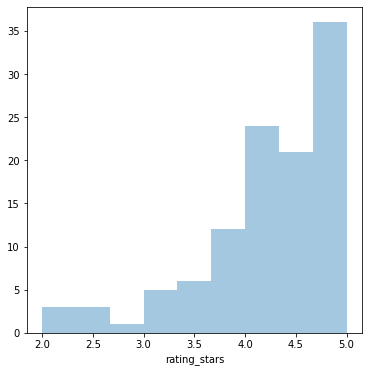

In [71]:
fig = plt.figure(figsize=(6, 6))
sns.distplot(makeup2.rating_stars, kde=False)
plt.show()

Most of the items have ratings higher than 4 stars. Since I want to find the best products, I will set 4.5 stars as my threshold.

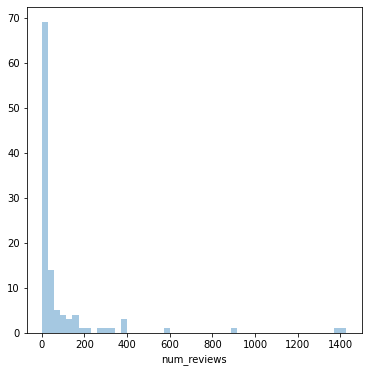

In [70]:
fig = plt.figure(figsize=(6, 6))
sns.distplot(makeup2.num_reviews, kde=False)
plt.show()

The above figure shows that most of the numbers of reviews are below 200. However, because of some large numbers of reviews, the distribution is strongly right-skewed. It is hard for me to find a great threshould. As both the number of reviews and the number of likes can indicate how popular a product is, I then take a look at the distribution for the number of likes.

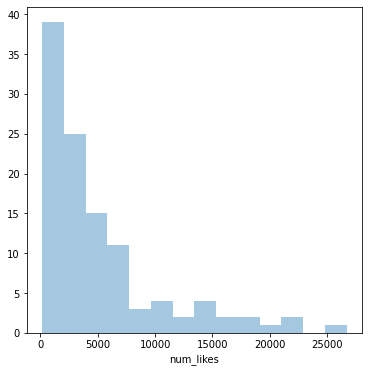

In [69]:
fig = plt.figure(figsize=(6, 6))
sns.distplot(makeup2.num_likes, kde=False)
plt.show()

It can be found that most of the products have number of likes between 0 and 5000. Products that have higher than 5000 likes should be outstanding. 

In [72]:
# Filter: rating_stars above 4.5, num_likes above 5000, price_dollar below 100
min_rating = 4.5
min_num_reviews = 0
min_num_likes = 5000
makeup2 = makeup2.loc[(makeup2['rating_stars']>min_rating) & (makeup2['num_reviews']>min_num_reviews) & (makeup2['num_likes']>min_num_likes)].reset_index(drop=True)
makeup2

,brand_name,product_name,rating_stars,num_reviews,num_likes,price_dollar
0,Rare Beauty by Selena Gomez,Liquid Touch Brightening Concealer,4.6,41.0,13400.0,25.00
1,Rare Beauty by Selena Gomez,Soft Pinch Liquid Blush,4.8,82.0,26700.0,26.00
2,Rare Beauty by Selena Gomez,Lip Souffle Matte Cream Lipstick,4.8,69.0,22800.0,26.00
3,Natasha Denona,Glam Eyeshadow Palette,4.9,29.0,14700.0,87.00
4,Rare Beauty by Selena Gomez,Positive Light Liquid Luminizer Highlight,4.7,21.0,14600.0,29.00
5,Rare Beauty by Selena Gomez,Perfect Strokes Matte Liquid Liner,4.7,37.0,6200.0,25.00
6,Tower 28 Beauty,ShineOn Milky Lip Jelly Gloss,5.0,19.0,9300.0,18.00
7,Melt Cosmetics,Digital Dust Duo Blush,4.6,7.0,6100.0,52.69
8,Dior,Lip Glow Lip Balm & Lip Maximizer Plumping Glo...,5.0,4.0,7900.0,68.00
9,Tatcha,Mini Liquid Silk Canvas: Featherweight Protect...,4.6,1429.0,13000.0,28.00


### Final List

Only 13 items satisfy my criteria. Let's check what is the most expensive product in the list:

In [75]:
makeup2.sort_values(by='price_dollar', ascending=False)

,brand_name,product_name,rating_stars,num_reviews,num_likes,price_dollar
3,Natasha Denona,Glam Eyeshadow Palette,4.9,29.0,14700.0,87.00
13,Gucci,Gucci Poudre De Beauté Éclat Soleil Bronzing P...,4.8,74.0,11100.0,81.00
8,Dior,Lip Glow Lip Balm & Lip Maximizer Plumping Glo...,5.0,4.0,7900.0,68.00
7,Melt Cosmetics,Digital Dust Duo Blush,4.6,7.0,6100.0,52.69
11,IT Cosmetics,Your Skin But Better Foundation + Skincare,4.6,205.0,7100.0,52.00
12,PAT McGRATH LABS,Lip Fetish Divinyl Lip Shine,4.6,18.0,9400.0,48.00
4,Rare Beauty by Selena Gomez,Positive Light Liquid Luminizer Highlight,4.7,21.0,14600.0,29.00
9,Tatcha,Mini Liquid Silk Canvas: Featherweight Protect...,4.6,1429.0,13000.0,28.00
1,Rare Beauty by Selena Gomez,Soft Pinch Liquid Blush,4.8,82.0,26700.0,26.00
2,Rare Beauty by Selena Gomez,Lip Souffle Matte Cream Lipstick,4.8,69.0,22800.0,26.00


The most expensive product is "Glam Eyeshadow Palette" from "Natasha Denona", which costs \\$87. I still have some room to reach my budget of \\$100. So let's combine two different products to make the most use of my budget. To ensure that my combinations make sense, I set the following criteria:
1. The two products should not belong to the same product type. For example, they should not both be "Blush".
2. The combinations should be ordered firstly by the total price, secondly by the total rating, thirdly by the total number of likes, and finally by the total number of reviews.

In [92]:
makeup_two_combinations = {'combination':[], 'total_price_dollar':[], 
                           'total_rating_stars':[], 'total_num_likes':[], 'total_num_reviews':[]}

for i in range(0, makeup2.shape[0]):
    first_item = makeup2.iloc[i]
    for j in range(i+1, makeup2.shape[0]):
        second_item = makeup2.iloc[j]
        # Check if two products are similar by comparing their names
        similar = 0
        for word in first_item['product_name'].split(' '):
            if word in second_item['product_name']:
                similar += 1
        total_price_dollar = first_item['price_dollar'] + second_item['price_dollar']
        if similar == 0 and total_price_dollar <= 100:
            combination = first_item['product_name'] + ' AND ' + second_item['product_name']
            total_rating_stars = first_item['rating_stars'] + second_item['rating_stars']
            total_num_likes = first_item['num_likes'] + second_item['num_likes']
            total_num_reviews = first_item['num_reviews'] + second_item['num_reviews']
            # Append to the dictonary
            makeup_two_combinations['combination'].append(combination)
            makeup_two_combinations['total_price_dollar'].append(total_price_dollar)
            makeup_two_combinations['total_rating_stars'].append(total_rating_stars)
            makeup_two_combinations['total_num_likes'].append(total_num_likes)
            makeup_two_combinations['total_num_reviews'].append(total_num_reviews)
makeup_two_combinations = pd.DataFrame(makeup_two_combinations)
makeup_two_combinations = makeup_two_combinations.sort_values(by=['total_price_dollar', 'total_rating_stars',
                                                                  'total_num_likes', 'total_num_reviews'], 
                                                              ascending=False).reset_index(drop=True)

In [93]:
makeup_two_combinations.head(5)

,combination,total_price_dollar,total_rating_stars,total_num_likes,total_num_reviews
0,Your Skin But Better Foundation + Skincare AND...,100.0,9.2,16500.0,223.0
1,ShineOn Milky Lip Jelly Gloss AND Gucci Poudre...,99.0,9.8,20400.0,93.0
2,Positive Light Liquid Luminizer Highlight AND ...,97.0,9.7,22500.0,25.0
3,Lip Glow Lip Balm & Lip Maximizer Plumping Glo...,96.0,9.6,20900.0,1433.0
4,Soft Pinch Liquid Blush AND Lip Glow Lip Balm ...,94.0,9.8,34600.0,86.0


In [94]:
for i in range(5):
    print("First combination: %s, the total price is %d" %(makeup_two_combinations.iloc[i, 0], makeup_two_combinations.iloc[i, 1]))

First combination: Your Skin But Better Foundation + Skincare AND Lip Fetish Divinyl Lip Shine, the total price is 100
First combination: ShineOn Milky Lip Jelly Gloss AND Gucci Poudre De Beauté Éclat Soleil Bronzing Powder, the total price is 99
First combination: Positive Light Liquid Luminizer Highlight AND Lip Glow Lip Balm & Lip Maximizer Plumping Gloss Set, the total price is 97
First combination: Lip Glow Lip Balm & Lip Maximizer Plumping Gloss Set AND Mini Liquid Silk Canvas: Featherweight Protective Primer, the total price is 96
First combination: Soft Pinch Liquid Blush AND Lip Glow Lip Balm & Lip Maximizer Plumping Gloss Set, the total price is 94


Here it is! Now I don't need to worry about checking hundreds of items that I know nothing about, but to just check couples of items in my top list!